# LIBRARIES

In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow import keras

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.set_random_seed(2019)

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [ ]:
!apt-get install tree
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 43.0 kB of archives.
After this operation, 115 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tree amd64 1.8.0-1 [43.0 kB]
Fetched 43.0 kB in 0s (123 kB/s)
Selecting previously unselected package tree.
(Reading database ... 122518 files and directories currently installed.)
Preparing to unpack .../tree_1.8.0-1_amd64.deb ...
Unpacking tree (1.8.0-1) ...
Setting up tree (1.8.0-1) ...
Processing triggers for man-db (2.9.1-1) ...
.
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

10 directories


In [ ]:
def load_data(dir_path, img_size=(100,100)):
    """

    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
IMG_DIR = '/content/IVC_DATA/'
# split the data by train/val/test
for class_name in os.listdir(IMG_DIR):
    if not class_name.startswith('.'):
        num_images = len(os.listdir(IMG_DIR + class_name))
        for (n, file_name) in enumerate(os.listdir(IMG_DIR + class_name)):
            img_path = IMG_DIR + class_name + '/' + file_name
            if n < 5:
                shutil.copy(img_path, 'TEST/' + class_name.upper() + '/' + file_name)
            elif n < 0.8*num_images:
                shutil.copy(img_path, 'TRAIN/'+ class_name.upper() + '/' + file_name)
            else:
                shutil.copy(img_path, 'VAL/'+ class_name.upper() + '/' + file_name)

print("IMG_DIR: ", IMG_DIR)
print("class_name: ", class_name)
print("num_images: ", num_images)
print("file_name: ", file_name)
print("img_path: ", img_path)

IMG_DIR:  /content/IVC_DATA/
class_name:  .ipynb_checkpoints
num_images:  22
file_name:  834.PNG
img_path:  /content/IVC_DATA/NO/834.PNG


In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 13.75it/s]
<ipython-input-3-ac77e3abb271>:19: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



32 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 93.21it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 65.94it/s]

10 images loaded from VAL/ directory.


In [ ]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Motif: {}'.format(labels_dict[index]))
        plt.show()

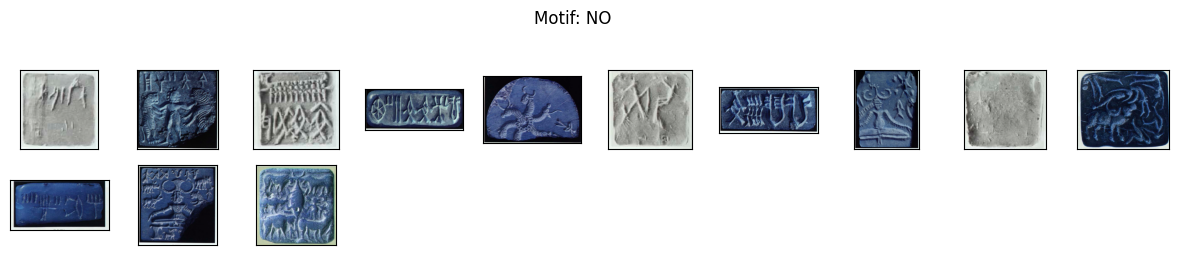

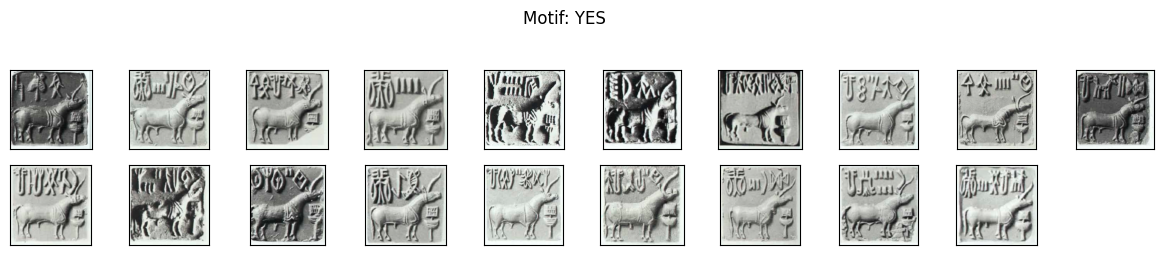

In [ ]:
plot_samples(X_train, y_train, labels, 50)

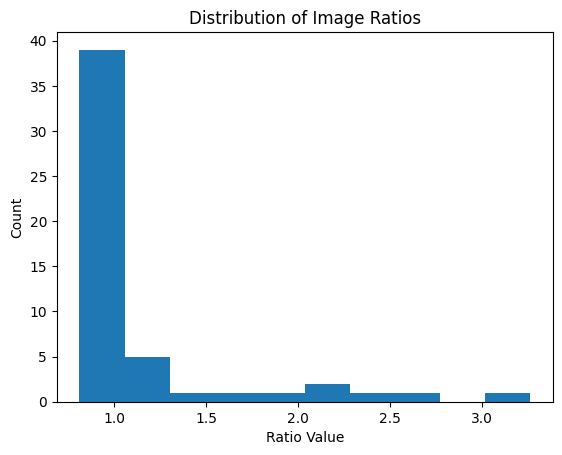

In [ ]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])

plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [ ]:
def preprocess_imgs(set_name, img_size):

    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [ ]:
X_train_prep = preprocess_imgs(set_name=X_train, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val, img_size=IMG_SIZE)

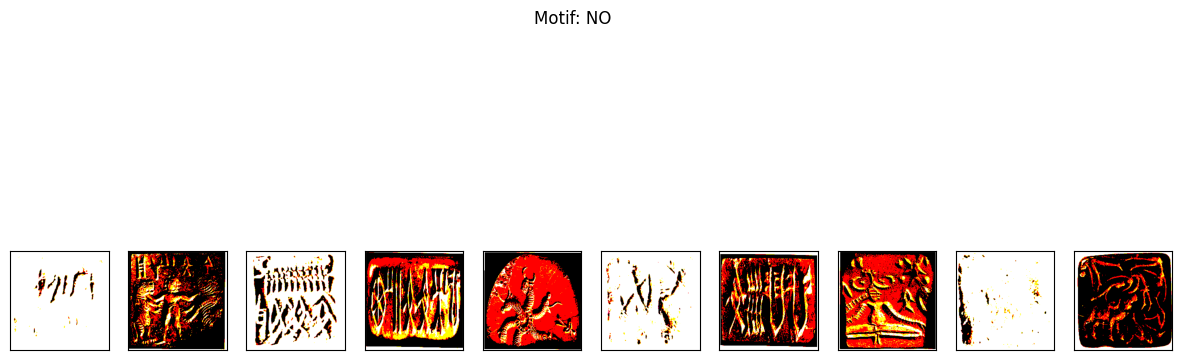

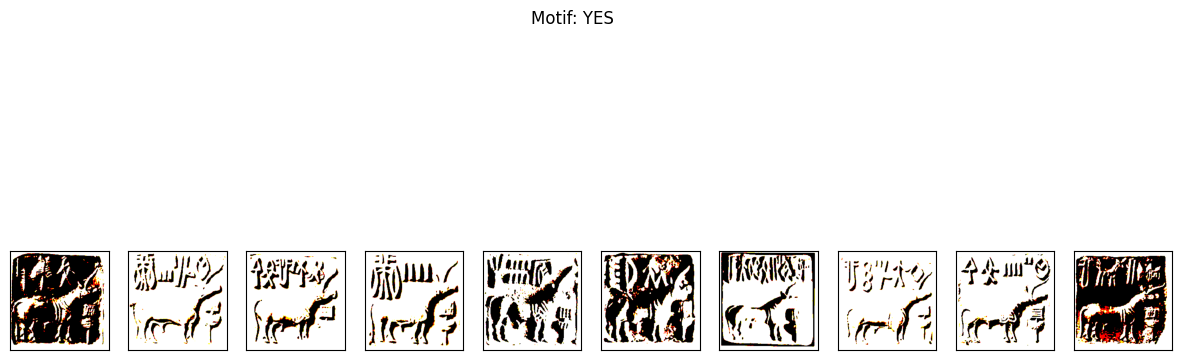

In [ ]:
plot_samples(X_train_prep, y_train, labels, 10)

In [ ]:

#  augumenting the data based on the following conditions

demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


os.mkdir('augmented_images')

if not os.path.exists('augmented_images/YES'):
    os.mkdir('augmented_images/YES')

directory = 'TRAIN/YES'
for filename in os.listdir(directory):
    # Load the image and convert it to a numpy array
    img = load_img(os.path.join(directory, filename))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Apply the augmentation to the image and save the resulting images to disk
    i = 0
    for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='augmented_images/YES', save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > 10:
            break



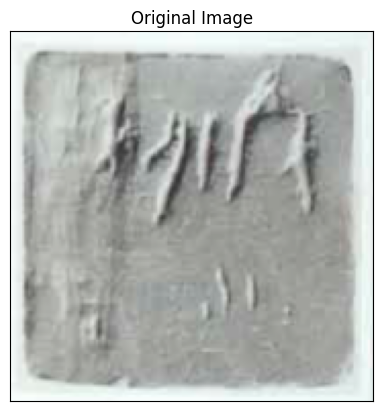

FileNotFoundError: ignored

<Figure size 1500x600 with 0 Axes>

In [ ]:

if not os.path.exists('augmented_images/NO'):
    os.mkdir('augmented_images/NO')

directory = 'TRAIN/NO'
for filename in os.listdir(directory):
    # Load the image and convert it to a numpy array
    img = load_img(os.path.join(directory, filename))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Apply the augmentation to the image and save the resulting images to disk
    i = 0
    for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='augmented_images/NO', save_prefix='aug_', save_format='jpg'):
        i += 1
        if i > 10: # Generate 5 augmented images per input image
            break


plt.imshow(X_train[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview'):
    img = cv2.imread('preview/' + img)  # add directory path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i >= 3*7:  # change loop condition
        break
plt.suptitle('Augmented Images')
plt.show()

In [ ]:
!rm -rf preview/

NameError: ignored

In [ ]:
TRAIN_DIR = '/content/augmented_images'
VAL_DIR = 'VAL'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',

    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 401 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [ ]:
train_generator

In [ ]:
# Define the model architecture
from tensorflow.keras import layers
model = keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224, 224, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2,'softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = 10
)


Epoch 1/10
13/13 [==============================] - 64s 5s/step - loss: 1.1117 - accuracy: 0.6459 - val_loss: 0.6925 - val_accuracy: 0.6250
Epoch 2/10
13/13 [==============================] - 54s 4s/step - loss: 0.4533 - accuracy: 0.7781 - val_loss: 0.8628 - val_accuracy: 0.3125
Epoch 3/10
13/13 [==============================] - 58s 4s/step - loss: 0.2957 - accuracy: 0.8554 - val_loss: 0.5156 - val_accuracy: 0.8125
Epoch 4/10
13/13 [==============================] - 56s 4s/step - loss: 0.2649 - accuracy: 0.8928 - val_loss: 0.4368 - val_accuracy: 0.8125
Epoch 5/10
13/13 [==============================] - 57s 4s/step - loss: 0.2330 - accuracy: 0.9152 - val_loss: 0.3518 - val_accuracy: 0.9062
Epoch 6/10
13/13 [==============================] - 57s 4s/step - loss: 0.2435 - accuracy: 0.9002 - val_loss: 0.3978 - val_accuracy: 0.8438
Epoch 7/10
13/13 [==============================] - 57s 4s/step - loss: 0.1920 - accuracy: 0.9302 - val_loss: 0.2913 - val_accuracy: 0.8438
Epoch 8/10
13/13 [==

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)      

In [ ]:
# Evaluate the model on a test dataset

predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions[:,1]]

_, train_acc = model.evaluate(X_val_prep, y_val, verbose=0)
_, test_acc = model.evaluate(X_test_prep, y_test, verbose=0)


y_true = y_test

1/1 [==============================] - 1s 710ms/step


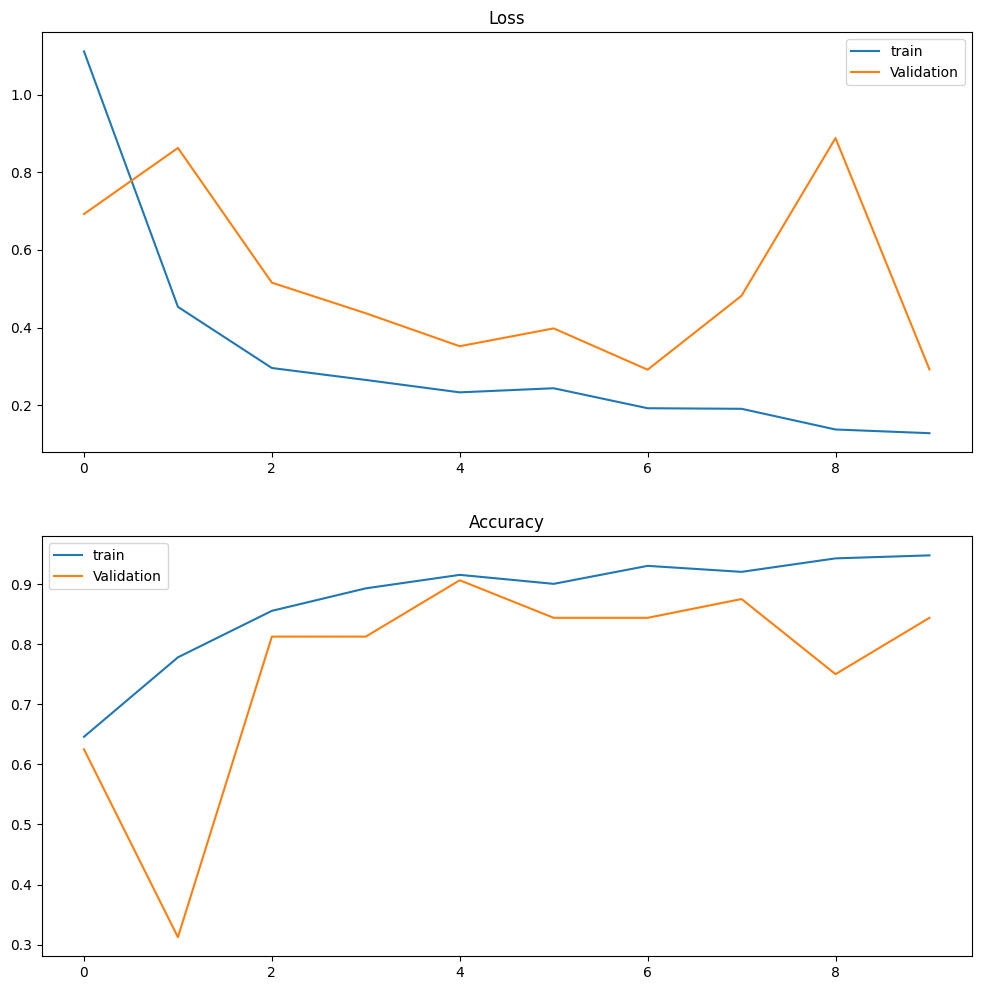

In [ ]:
from matplotlib import pyplot
pyplot.figure(figsize=(12,12))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='Validation')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='Validation')
pyplot.legend()
pyplot.show()

In [ ]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.900, Test: 0.700


In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

Accuracy: 0.700000
Precision: 0.625000
Recall: 1.000000
F1 score: 0.769231


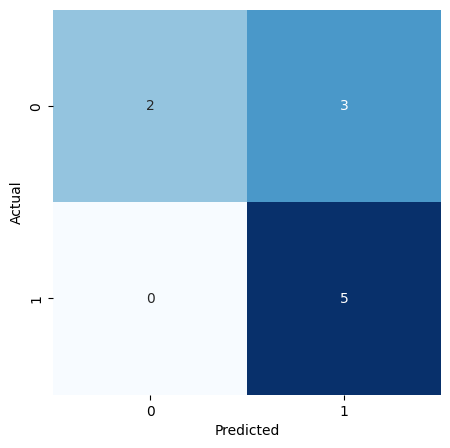

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()